## Import & Process Image

In [105]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import glob

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## EDA

In [17]:
# Import converted images
X = np.load('data/100x100.npy')
y = np.load('data/diagnosis.npy')

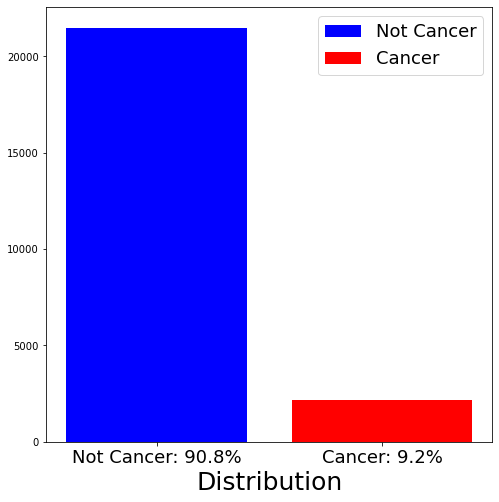

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
xlabel = 25
xtick = 18
x0 = (y==0).sum()
x1 = (y==1).sum()

ax.set_xlabel('Distribution', size=xlabel)

ax.bar(0, x0, color = 'b', label='Not Cancer')
ax.bar(1, x1, color = 'r', label='Cancer')
ax.set_xticks([0,1])
ax.set_xticklabels(['Not Cancer: 90.8%', 'Cancer: 9.2%'], size=xtick)
plt.legend(prop={'size': 18})
fig.show()

## Train Test Split for Train, validation, test set

In [18]:
# Train/test split for Train Set
XX_train, X_test, yy_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(XX_train, yy_train, test_size=0.2, random_state=42, stratify=yy_train)

## Pipeline

In [19]:
# Calculate imbalance data
ones = (y_train==1).sum()
zeros = (y_train==0).sum()
adj_ones = zeros/(ones+zeros)
adj_zero = ones/(ones+zeros)

print('Adjusted Zeros Ratio: {}'.format(adj_ones))
print('Adjusted Ones  Ratio: {}'.format(adj_zero))

class_weight = {1:adj_ones,
                0:adj_zero}

Adjusted Zeros Ratio: 0.9083702186694854
Adjusted Ones  Ratio: 0.09162978133051464


In [5]:
## Import Model
model = VGG16(include_top=False, input_shape=(100, 100, 3))

## Transfer Learning
new_model = Sequential()
for layer in model.layers[:-2]: # just exclude the last two FC layers
    layer.trainable = False
    new_model.add(layer)
new_model.add(Conv2D(512, (5, 5), activation = 'relu', padding = 'same'))
new_model.add(MaxPooling2D(2,2))
new_model.add(Flatten())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1, activation ='sigmoid'))

58892288/58889256 [==============================] - 1s 0us/step


In [114]:
opt = keras.optimizers.SGD(learning_rate=0.01)
new_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [115]:
history = new_model.fit(X_train, y_train, epochs=20, batch_size=32, class_weight=class_weight, validation_data=(X_test, y_test))

Epoch 1/20
474/474 [==============================] - 338s 714ms/step - loss: 0.0760 - accuracy: 0.7443 - recall_10: 0.8248 - val_loss: 0.9843 - val_accuracy: 0.5295 - val_recall_10: 0.9954
Epoch 2/20
474/474 [==============================] - 338s 712ms/step - loss: 0.0682 - accuracy: 0.7556 - recall_10: 0.8645 - val_loss: 0.4437 - val_accuracy: 0.7489 - val_recall_10: 0.8502
Epoch 3/20
474/474 [==============================] - 340s 718ms/step - loss: 0.0648 - accuracy: 0.7644 - recall_10: 0.8782 - val_loss: 0.4535 - val_accuracy: 0.7461 - val_recall_10: 0.8594
Epoch 4/20
474/474 [==============================] - 337s 711ms/step - loss: 0.0626 - accuracy: 0.7689 - recall_10: 0.8955 - val_loss: 0.2542 - val_accuracy: 0.8791 - val_recall_10: 0.5000
Epoch 5/20
474/474 [==============================] - 341s 719ms/step - loss: 0.0607 - accuracy: 0.7777 - recall_10: 0.8947 - val_loss: 0.4247 - val_accuracy: 0.7457 - val_recall_10: 0.8733
Epoch 6/20
474/474 [==============================

In [24]:
from src.functions import plot_accuracy, plot_loss, plot_recall

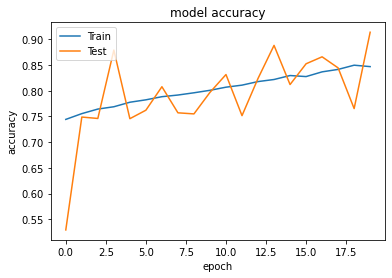

In [117]:
plot_accuracy(history)

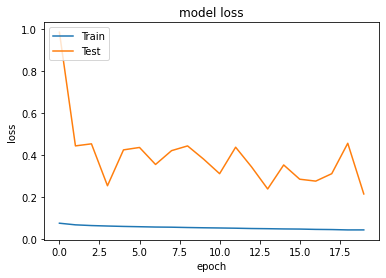

In [118]:
plot_loss(history)

In [119]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall_10', 'val_loss', 'val_accuracy', 'val_recall_10'])

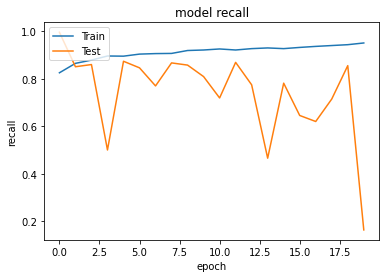

In [120]:
plot_recall(history, 'recall_10')

#### Saving Model

In [135]:
new_model.save('models/name_of_model.h5')

#### Importing Model

In [20]:
new_model = load_model('models/vgg_transfer_1.h5')

## Evaluation

### ROC AUC

In [108]:
# Predictions for Validation Set
y_val_pred = new_model.predict(X_val)

In [21]:
# Predictions for Test Set
y_test_pred = new_model.predict(X_test)

In [123]:
fpr, tpr, thres_roc = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr, tpr)

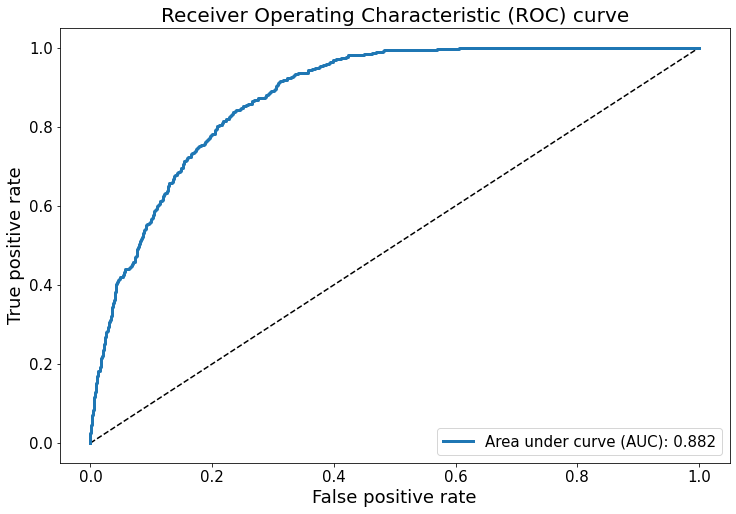

In [84]:
fig, ax = plt.subplots(figsize=(12,8))
ticks = np.arange(-0.2 ,1.2 , 0.2)

title_size = 20
label_size = 18
legend_size = 15
tick_size = 15

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, label='Area under curve (AUC): {:.3f}'.format(auc_keras), linewidth=3.0)

ax.set_title('Receiver Operating Characteristic (ROC) curve', size=title_size)

ax.set_xlabel('False positive rate', size=label_size)
ax.set_ylabel('True positive rate', size=label_size)

ax.set_xticklabels(ticks, fontsize=tick_size)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_yticklabels(ticks, fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.legend(loc='best', fontsize=legend_size)
fig.show()
# fig.savefig('img/roc_auc.png')

### Precision Recall Curve

In [25]:
precision, recall, thresh_pr_curve = precision_recall_curve(y_test, y_test_pred)

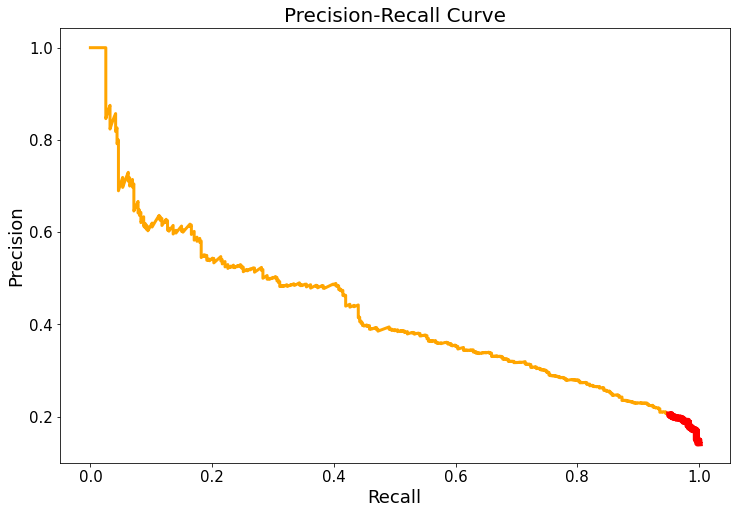

In [33]:
fig, ax = plt.subplots(figsize=(12,8))
ticks = np.arange(-0.2 ,1.2 , 0.2)

title_size = 20
label_size = 18
legend_size = 15
tick_size = 15
thresh_loc = len(recall[recall>=0.95])

ax.plot(recall, precision, color='orange', linewidth=3.0)
ax.plot(recall[:thresh_loc], precision[:thresh_loc], marker='*', color='red', linewidth=7.0)

ax.set_title('Precision-Recall Curve', size=title_size)

ax.set_xticklabels(ticks, fontsize=tick_size)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_yticklabels(ticks, fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel('Recall', size=label_size)
ax.set_ylabel('Precision', size=label_size)

fig.show()
fig.savefig('img/pr_curve.png')

In [101]:
# The most liberal threshold given that recall >= 95%
liberal_thresh = thresh_pr_curve[:thresh_loc][-1]
liberal_thresh

0.022247791

In [36]:
f1_lst = [f1_score(y_test, y_test_pred >= i) for i in thresh_pr_curve[:thresh_loc]]

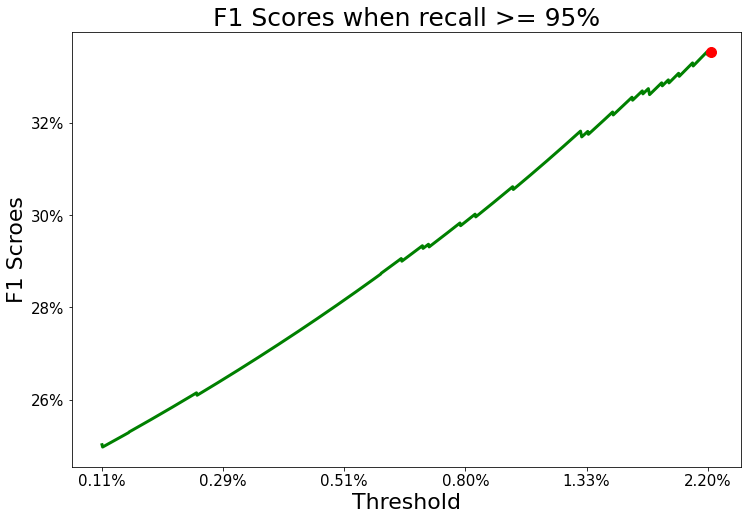

In [122]:
fig, ax = plt.subplots(figsize=(12,8))
xticks = ['0.11%', '0.29%', '0.51%', '0.80%', '1.33%', '2.20%']
yticks = ['26%', '28%', '30%', '32%']
f1_x = np.arange(len(f1_lst))
max_index_col = np.argmax(f1_lst, axis=0)

title_size = 25
label_size = 22
legend_size = 15
tick_size = 15

ax.plot(f1_x, f1_lst, color='green', linewidth=3.0)
ax.plot(f1_x[max_index_col], f1_lst[max_index_col], 
        marker='.', markersize=20, color='red')

ax.set_title('F1 Scores when recall >= 95%', size=title_size)

ax.set_xticks([0,200,400,600,800,1000])
ax.set_yticks([0.26,0.28,0.30,0.32])
ax.set_xticklabels(xticks, fontsize=tick_size)
ax.set_yticklabels(yticks, fontsize=tick_size)

ax.set_xlabel('Threshold', size=label_size)
ax.set_ylabel('F1 Scroes', size=label_size)

fig.show()
fig.savefig('img/f1.png')

In [113]:
# The highest F1 score threshold given that recall >= 95%.
final_thresh = thresh_pr_curve[max_index_col]

### Confusion Matrix

In [109]:
from src.functions import matrix_score

#### Base Model (Random choice based on probability)

In [106]:
y_base = np.random.choice(2, len(y_test), p=[adj_ones,adj_zero])
matrix_score(y_test, y_base)

[[  38  396]
 [ 379 3918]]
Recall:    0.088
Precision: 0.091
Accuracy:  0.836
ROC AUC:   0.500


In [204]:
f1_score(y_test, y_base)

0.05959475566150179

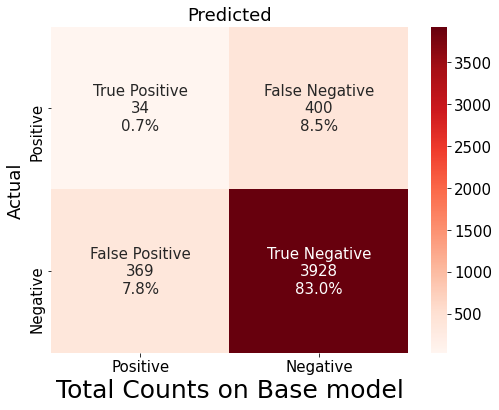

In [225]:
plt.rcParams.update({'font.size': 15})
title=25
tick = 14
label= 18

class_labels = ['Positive', 'Negative']
cm = confusion_matrix(y_test, y_base, normalize=None)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
cm = np.array([[tp, fn], [fp, tn]])

group_names = ['True Positive','False Negative','False Positive','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig,ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm,cmap='Reds', annot=labels, fmt='', ax=ax,xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Predicted', size=label)
ax.set_xlabel('Total Counts on Base model', size=title)
ax.set_ylabel('Actual', size=label)
fig.show()
fig.savefig('img/base_model_cm.png');

#### Validation Set

In [115]:
matrix_score(y_val, y_val_pred >= final_thresh)

[[ 334   13]
 [1258 2180]]
Recall:    0.963
Precision: 0.210
Accuracy:  0.664
ROC AUC:   0.798


In [116]:
f1_score(y_val, y_val_pred>=final_thresh)

0.3445074780814853

#### Test Set

In [117]:
matrix_score(y_test, y_test_pred >= final_thresh)

[[ 413   21]
 [1615 2682]]
Recall:    0.952
Precision: 0.204
Accuracy:  0.654
ROC AUC:   0.788


In [119]:
f1_score(y_test, y_test_pred>=final_thresh)

0.33549959382615757

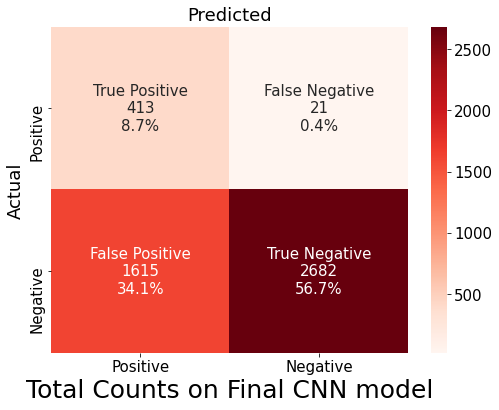

In [125]:
plt.rcParams.update({'font.size': 15})
title=25
tick = 14
label= 18

class_labels = ['Positive', 'Negative']
cm = confusion_matrix(y_test,(y_test_pred >= final_thresh).astype(int),normalize=None)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
cm = np.array([[tp, fn], [fp, tn]])

group_names = ['True Positive','False Negative','False Positive','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm,cmap='Reds', annot=labels, fmt='', ax=ax,xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Predicted', size=label)
ax.set_xlabel('Total Counts on Final CNN model', size=title)
ax.set_ylabel('Actual', size=label)
fig.show()
fig.savefig('img/final_CNN.png');